In [2]:
import numpy as np
from function import *
import matplotlib.pyplot as plt
from itertools import product

speed_uav =30
speed_ugv =10
survey_time = 1/6
waypoints = [(12, 50), (20, 25), (19, 36)]
plan_output = "0 -> 2 -> 1 -> 0"
# plan_output = "0 -> 1 -> 2 -> 0" # Funtion enumerate This (only the mid of tour)
radii = [3]


In [3]:
def plot_solution_combined(waypoints, plan_output, radii, speed_ugv, speed_uav, survey_time, plot_graph=True):
    UGVdistances = []
    UAV_total_distances = []
    
    # Create all possible permutations of radii for waypoints
    for radius_combination in product(radii, repeat=len(waypoints)-1):
        ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
        ordered_points.append(ordered_points[0])

        if plot_graph:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.scatter(*zip(*ordered_points))
        UGV_outer_path=[]
        UGV_path = [ordered_points[0]]
        UGV_inter_path = []
        UAV_path = []
        UAV_distances = []
        UGV_inter_distances = []
        UGV_inter_distances_withDorne = []
        UGV_inter_distance_withoutDrone = []
        for i, point in enumerate(ordered_points[:-1]):
            if plot_graph:
                plt.annotate(i, (point[0] + 0.5, point[1] + 0.5))
            current_radius = radius_combination[i % len(radius_combination)]
            
            # Exclude the start and end points from circles
            if 0 < i < len(ordered_points) - 2:
                
                # calculate angle and chords for the current waypoint
                angle = angle_between_points(ordered_points[i-1], ordered_points[i])
                nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
                chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
                chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
                
                # calculate meeting point
                final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(ordered_points[i],current_radius, chord_start, chord_end, speed_ugv, speed_uav, survey_time)
                
                # Visualize without creating a new figure
                circle = plt.Circle(point, current_radius, color='b', fill=False)
                ax.add_artist(circle)
                plt.scatter(point[0],point[1], color='g', label='Intreset Point (Half-way for UAV)')
                plt.scatter(chord_start[0],chord_start[1], color='r', label='Takeoff Point (UGV & UAV split)')
                UGV_outer_path.extend([chord_start])
                # ax.plot(*ordered_points[i],*chord_start,linestyle='-', marker='o')
                ax.plot([chord_start[0], point[0], final_meeting_point[0]], [chord_start[1], point[1], final_meeting_point[1]], 'g--',label='Path of UGV w')
                ax.plot([chord_start[0], point[0], final_meeting_point[0]], [chord_start[1], point[1], final_meeting_point[1]], 'g--',label='Path of UAV')
                ax.plot([chord_start[0], final_meeting_point[0]], [chord_start[1], final_meeting_point[1]], 'r-',label='Path of UGV without Drone')
                ax.plot([final_meeting_point[0],chord_end[0] ], [final_meeting_point[1], chord_end[1]], 'm-',label='Path of UGV with Drone')
                ax.scatter(final_meeting_point[0], final_meeting_point[1], color='y', marker='X', s=100,label='Meeting Point')
                
                print(f"Wait time: {final_wait_time:.2f}")
                
                UAV_path.extend([chord_start, ordered_points[i], final_meeting_point])
                UGV_inter_path.extend([chord_start, final_meeting_point])
                
                UAV_distance_segment = sum(np.linalg.norm(np.array(UAV_path[j]) - np.array(UAV_path[j+1])) for j in range(len(UAV_path) - 1))
                UGV_inter_distance_segment = np.linalg.norm(np.array(chord_start) - np.array(final_meeting_point))
                UAV_distances.append(UAV_distance_segment)
                UGV_inter_distances.append(UGV_inter_distance_segment)
                
                UGV_path.append(final_meeting_point)
        
        UGV_path.append(ordered_points[-1])
        # if plot_graph:
        #     ax.plot(*zip(*ordered_points), linestyle='b-', marker='o')
        
        UGV_distance = sum(np.linalg.norm(np.array(UGV_path[i]) - np.array(UGV_path[i+1])) for i in range(len(UGV_path) - 1))
        
        UGVdistances.append(UGV_distance)
        UAV_total_distances.append(sum(UAV_distances))

        if plot_graph:
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title(f'TSP Solution, radii = {radius_combination}')
            plt.grid()
            plt.axis('equal')
            plt.show()
    
    return UGVdistances, UAV_total_distances, UGV_inter_distances, UAV_path, UGV_path



Wait time: 0.00
Wait time: 0.30


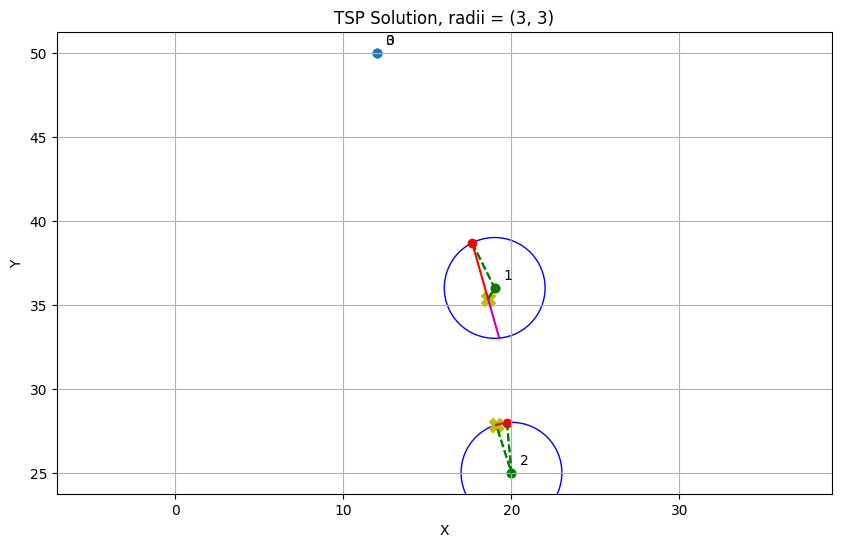

In [4]:
UGVdistances, UAV_total_distances, UGV_inter_distances, UAV_path,UGV_path= plot_solution_combined(waypoints, plan_output, radii,speed_ugv, speed_uav, survey_time, plot_graph=True)


Wait time: 0.00
Wait time: 0.30


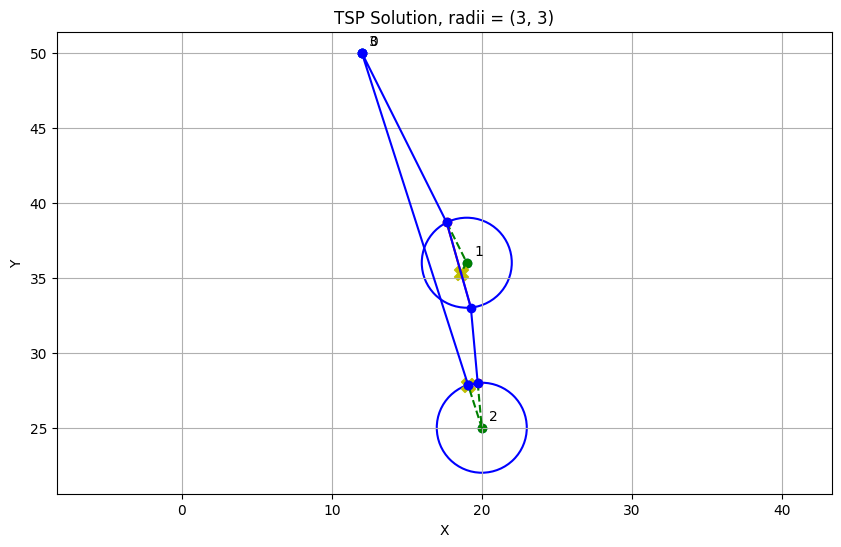

In [8]:
def plot_solution_final_corrected(waypoints, plan_output, radii, speed_ugv, speed_uav, survey_time, plot_graph=True):
    UGVdistances = []
    UAV_total_distances = []
    
    # Create all possible permutations of radii for waypoints
    for radius_combination in product(radii, repeat=len(waypoints)-1):
        ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
        ordered_points.append(ordered_points[0])

        if plot_graph:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.scatter(*zip(*ordered_points))
        UGV_outer_path = [ordered_points[0]]
        UGV_path = [ordered_points[0]]
        UAV_path = []
        UAV_distances = []
        UGV_inter_distances = []
        
        for i, point in enumerate(ordered_points[:-1]):
            if plot_graph:
                plt.annotate(i, (point[0] + 0.5, point[1] + 0.5))
            current_radius = radius_combination[i % len(radius_combination)]
            
            # Exclude the start and end points from circles
            if 0 < i < len(ordered_points) - 2:
                # calculate angle and chords for the current waypoint
                angle = angle_between_points(ordered_points[i-1], ordered_points[i])
                nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
                chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
                chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
                
                # calculate meeting point
                final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(ordered_points[i],current_radius, chord_start, chord_end, speed_ugv, speed_uav, survey_time)
                
                # Visualize without creating a new figure
                draw_circle(ax, ordered_points[i], current_radius)
                plt.scatter(point[0],point[1], color='g', label='Interest Point (Half-way for UAV)')
                plt.scatter(chord_start[0],chord_start[1], color='r', label='Takeoff Point (UGV & UAV split)')
                UGV_outer_path.append(chord_start)
                ax.plot([chord_start[0], point[0], final_meeting_point[0]], [chord_start[1], point[1], final_meeting_point[1]], color='g', linestyle='--', label='Path of UAV')
                ax.plot([chord_start[0], final_meeting_point[0]], [chord_start[1], final_meeting_point[1]], color='r', linestyle='-', label='Path of UGV without Drone')
                ax.plot([final_meeting_point[0],chord_end[0] ], [final_meeting_point[1], chord_end[1]], color='m', linestyle='-', label='Path of UGV with Drone')
                plt.scatter(final_meeting_point[0], final_meeting_point[1], color='y', marker='X', s=100, label='Meeting Point')
                
                print(f"Wait time: {final_wait_time:.2f}")
                
                UAV_path.extend([chord_start, ordered_points[i], final_meeting_point])
                UAV_distance_segment = sum(np.linalg.norm(np.array(UAV_path[j]) - np.array(UAV_path[j+1])) for j in range(len(UAV_path) - 1))
                UGV_inter_distance_segment = np.linalg.norm(np.array(chord_start) - np.array(final_meeting_point))
                UAV_distances.append(UAV_distance_segment)
                UGV_inter_distances.append(UGV_inter_distance_segment)
                
                UGV_path.append(final_meeting_point)
                
            # Connect the last meeting point to the next chord start
            if i > 0:
                UGV_outer_path.append(chord_end)
        
        UGV_outer_path.append(ordered_points[-1])
        UGV_path.append(ordered_points[-1])
        
        if plot_graph:
            ax.plot(*zip(*UGV_outer_path), color='b', linestyle='-', marker='o')
            UGV_distance = sum(np.linalg.norm(np.array(UGV_path[i]) - np.array(UGV_path[i+1])) for i in range(len(UGV_path) - 1))
            UGVdistances.append(UGV_distance)
            UAV_total_distances.append(sum(UAV_distances))
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title(f'TSP Solution, radii = {radius_combination}')
            plt.grid()
            plt.axis('equal')
            plt.show()
    
    return UGVdistances, UAV_total_distances, UGV_inter_distances, UAV_path, UGV_path,UGV_outer_path



In [33]:
def plot_solution_final_refined_v2(waypoints, plan_output, radii, speed_ugv, speed_uav, survey_time, plot_graph=True):
    UGVdistances = []
    UAV_total_distances = []
    UGV_outer_path_distances = []
    
    # Create all possible permutations of radii for waypoints
    for radius_combination in product(radii, repeat=len(waypoints)-1):
        ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
        ordered_points.append(ordered_points[0])

        if plot_graph:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.scatter(*zip(*ordered_points))
        UGV_outer_path = [ordered_points[0]]
        UGV_path = [ordered_points[0]]
        UAV_path = []
        UAV_distances = []
        UGV_inter_distances = []
        
        for i, point in enumerate(ordered_points[:-1]):
            if plot_graph:
                plt.annotate(i, (point[0] + 0.5, point[1] + 0.5))
            current_radius = radius_combination[i % len(radius_combination)]
            
            # Exclude the start and end points from circles
            if 0 < i < len(ordered_points) - 2:
                # calculate angle and chords for the current waypoint
                angle = angle_between_points(ordered_points[i-1], ordered_points[i])
                nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
                chord_start = point_on_circle(ordered_points[i], angle - np.pi, current_radius)
                chord_end = point_on_circle(ordered_points[i], nextangle, current_radius)
                
                # calculate meeting point
                final_meeting_point, final_wait_time = find_meeting_point_with_survey_final(ordered_points[i],current_radius, chord_start, chord_end, speed_ugv, speed_uav, survey_time)
                
                # Visualize without creating a new figure
                draw_circle(ax, ordered_points[i], current_radius)
                plt.scatter(point[0],point[1], color='g', label='Interest Point (Half-way for UAV)')
                plt.scatter(chord_start[0],chord_start[1], color='r', label='Takeoff Point (UGV & UAV split)')
                UGV_outer_path.append(chord_start)
                ax.plot([final_meeting_point[0],chord_end[0] ], [final_meeting_point[1], chord_end[1]], 'm-',label='Path of UGV with Drone')
                ax.plot([chord_start[0], point[0], final_meeting_point[0]], [chord_start[1], point[1], final_meeting_point[1]], color='g', linestyle='--', label='Path of UAV')
                ax.plot([chord_start[0], final_meeting_point[0]], [chord_start[1], final_meeting_point[1]], color='r', linestyle='-', label='Path of UGV without Drone')
                plt.scatter(final_meeting_point[0], final_meeting_point[1], color='y', marker='X', s=100, label='Meeting Point')
                
                print(f"Wait time: {final_wait_time:.2f}")
                
                UAV_path.extend([chord_start, ordered_points[i], final_meeting_point])
                UAV_distance_segment = sum(np.linalg.norm(np.array(UAV_path[j]) - np.array(UAV_path[j+1])) for j in range(len(UAV_path) - 1))
                UGV_inter_distance_segment = np.linalg.norm(np.array(chord_start) - np.array(final_meeting_point))
                UAV_distances.append(UAV_distance_segment)
                UGV_inter_distances.append(UGV_inter_distance_segment)
                
                UGV_path.append(final_meeting_point)
                
            # Connect the last meeting point to the next chord start
            if i > 0:
                UGV_outer_path.append(chord_end)
        #add the last chord_end and the endpoints:
        UGV_outer_path.append(chord_end)
        UGV_outer_path.append(ordered_points[-1])
        UGV_path.append(ordered_points[-1])
        
        # Calculating the UGV_outer_path distance
        UGV_outer_distance = sum(compute_distance(UGV_outer_path[i], UGV_outer_path[i+1]) for i in range(len(UGV_outer_path) - 1))
        UGV_outer_path_distances.append(UGV_outer_distance)
        
        if plot_graph:
            # Plot each pair of points in the UGV_outer_path list
            for i in range(0, len(UGV_outer_path), 2):
                print(*UGV_outer_path[i:i+2])
                ax.plot(*zip(*UGV_outer_path[i:i+2]), color='b', linestyle='-', marker='o')
                
            UGV_distance = sum(np.linalg.norm(np.array(UGV_path[i]) - np.array(UGV_path[i+1])) for i in range(len(UGV_path) - 1))
            UGVdistances.append(UGV_distance)
            UAV_total_distances.append(sum(UAV_distances))
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title(f'TSP Solution, radii = {radius_combination}')
            plt.grid()
            plt.axis('equal')
            plt.show()
            print(f"UGV Outer Path Distance: {UGV_outer_distance:.2f}")
    
    return UGVdistances, UAV_total_distances, UGV_inter_distances, UAV_path, UGV_path,UGV_outer_path,UGV_outer_path_distances


Wait time: 0.00
Wait time: 0.30
(12, 50) (17.658359213500127, 38.683281572999746)
(19.271607238127554, 33.01232038059689) (19.728392761872442, 27.98767961940311)
(19.08567281868865, 27.85727244159797) (19.08567281868865, 27.85727244159797)
(19.08567281868865, 27.85727244159797) (12, 50)


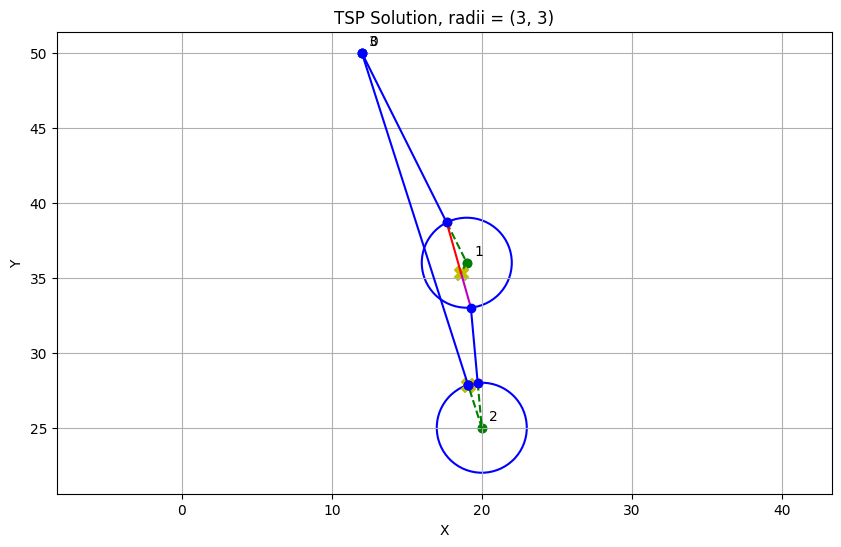

UGV Outer Path Distance: 47.50


In [34]:
# Sample run again
UGVdistances, UAV_total_distances, UGV_inter_distances, UAV_path, UGV_path,UGV_outer_path,UGV_outer_path_distances= plot_solution_final_refined_v2(waypoints, plan_output, radii, speed_ugv, speed_uav, survey_time, plot_graph=True)


In [35]:
UGV_outer_path_distances

[47.49842478983236]